<a href="https://colab.research.google.com/github/LasseRegin/02456-project/blob/master/predicting_resampled_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages and mount Google-Drive

Run the cell -> click the link -> Login with @beresourceful e-mail.

In [175]:
%%capture
!pip install pandas matplotlib google-cloud-bigquery scikit-learn google-cloud-storage

import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/BeResourceful/Tech/Software/Colab Notebooks/gcp-service-accounts/production-273114-444174d2a322.json"

# Download data

In [2]:
%matplotlib inline
from google.cloud import bigquery
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(palette='tab10')

# Init BigQuery client
client = bigquery.Client()

# Fetch transmissions and convert to DataFrame
df_transmissions_db = client.query(
"""
SELECT 
*
FROM `production-273114.sensor_data.transmissions_extended_view`
WHERE 
DATE(timestamp) <= "2020-07-11" AND
DATE(timestamp) >= "2020-07-01" AND
sensor_id in (
  "98",
  "99",
  "201",
  "202"
)
""").result().to_dataframe()

df_transmissions_db.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,device_id,sensor_id,event,timestamp,battery,temperature,humidity,moisture,ohms,antenna_strength,pressure,moisture_corrected_pine,moisture_corrected_spruce
0,3dfa03700001c0068c000094,e00fce6825a25e41b491d76a,202,test,2020-07-11 13:04:21.501000+00:00,2.98,18.5,67.5,13.8,63.0,None,0.0,15.201665,16.895146
1,3e13bde50001c0068c000071,e00fce6825a25e41b491d76a,98,test,2020-07-11 13:32:27.634000+00:00,2.98,24.5,44.0,14.4,46.0,None,0.0,15.745012,17.482495
2,3e18bfd60001c0068c000093,e00fce6825a25e41b491d76a,201,test,2020-07-11 13:37:55.811000+00:00,3.00,27.5,34.5,8.6,3254.0,None,0.0,10.015963,11.289489
3,3e068a000001c0068c000072,e00fce6825a25e41b491d76a,99,test,2020-07-11 13:18:02.381000+00:00,2.96,17.5,69.0,10.5,588.0,None,0.0,11.970066,13.401842
4,3d7844010001c0068c000071,e00fce6825a25e41b491d76a,98,test,2020-07-11 10:42:38.350000+00:00,2.98,23.5,49.0,14.3,48.0,None,0.0,15.669871,17.401270


# Extract moisture column and resample time series

In [74]:
df = (
    df_transmissions_db
    [['sensor_id', 'timestamp', 'moisture_corrected_pine']].copy()
    .rename(columns={'moisture_corrected_pine': 'moisture'})
    .set_index('timestamp')
    .groupby('sensor_id')
    .resample('h')
    .mean()
    .interpolate())
df.head()

moisture
sensor_id timestamp                           
201       2020-07-01 00:00:00+00:00  11.204828
          2020-07-01 01:00:00+00:00  11.229319
          2020-07-01 02:00:00+00:00  11.262142
          2020-07-01 03:00:00+00:00  11.288014
          2020-07-01 04:00:00+00:00  11.170655

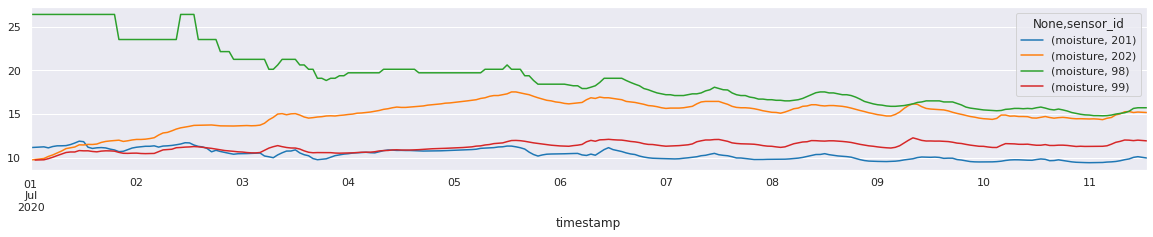

In [75]:
df.unstack(level=0).plot(figsize=(20, 3))

# Split in train/test

In [95]:
# Define split
train_fraction = 0.70
timestamps = df.index.get_level_values(level=1)
time_min, time_max = timestamps.min(), timestamps.max()
time_offset = pd.Timedelta(seconds=int((time_max - time_min).total_seconds() * train_fraction))
time_split = time_min + time_offset
print(f"Time between: {time_min} and {time_max}")
print(f"Using a {int(train_fraction * 100)}% train fraction")
print(f"Split at time: {time_split}")

dfs_train, dfs_test = [], []
for sensor_id in df.index.get_level_values(level=0).unique():
  df_sensor = df.loc[sensor_id]
  df_sensor['sensor_id'] = sensor_id
  df_sensor_train = df_sensor.loc[df_sensor.index < time_split]
  df_sensor_test = df_sensor.loc[df_sensor.index >= time_split]
  dfs_train.append(df_sensor_train)
  dfs_test.append(df_sensor_test)
df_train = pd.concat(dfs_train)
df_test = pd.concat(dfs_test)
df_train = df_train.reset_index().set_index(['sensor_id', 'timestamp'])
df_test = df_test.reset_index().set_index(['sensor_id', 'timestamp'])

print('')
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Time between: 2020-07-01 00:00:00+00:00 and 2020-07-11 13:00:00+00:00
Using a 70% train fraction
Split at time: 2020-07-08 09:06:00+00:00

Train shape: (711, 1)
Test shape: (304, 1)


# Construct shifted values (lag variables)

In [96]:
def create_shifted_variables(df):
  T = 24
  dfs = []
  for sensor_id in df.index.get_level_values(level=0).unique():
    df_shifted = pd.concat([df.loc[sensor_id].shift(t) for t in range(T)], axis=1)
    df_shifted['sensor_id'] = sensor_id
    dfs.append(df_shifted)
  df_shifted = pd.concat(dfs)
  df_shifted = df_shifted.reset_index().set_index(['sensor_id', 'timestamp'])
  df_shifted.columns = ['t0'] + [f"t-{t}" for t in range(1, T)]
  df_shifted.dropna(inplace=True)
  return df_shifted

df_train_shifted = create_shifted_variables(df=df_train)
df_test_shifted = create_shifted_variables(df=df_test)
print(f"Train shifted shape: {df_train_shifted.shape}")
print(f"Test shifted shape: {df_test_shifted.shape}")

Train shifted shape: (619, 24)
Test shifted shape: (212, 24)


# Train model

X_train: (619, 23)
y_train: (619,)
X_test: (212, 23)
y_test: (212,)
R^2 on test: 0.9987
RMSE: 0.09


t0    t0_pred     lower      upper
sensor_id timestamp                                                           
201       2020-07-09 09:00:00+00:00  10.064729  10.008730  9.835902  10.181558
          2020-07-09 10:00:00+00:00  10.127593  10.151647  9.978819  10.324475
          2020-07-09 11:00:00+00:00  10.106884  10.168173  9.995345  10.341001
          2020-07-09 12:00:00+00:00  10.097393  10.115955  9.943127  10.288783
          2020-07-09 13:00:00+00:00  10.117182  10.067256  9.894428  10.240084

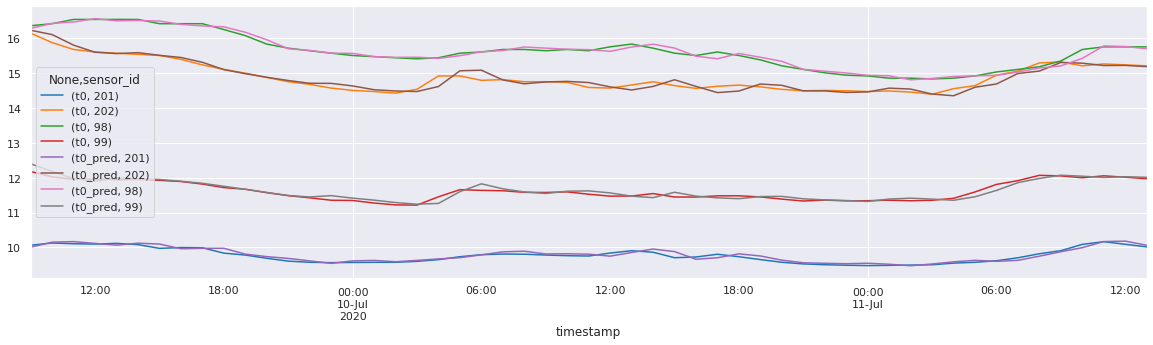

In [156]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Split in features and target
df_tmp = df_train_shifted.copy()
y_train = df_tmp.pop('t0').values
X_train = df_tmp.values
df_tmp = df_test_shifted.copy()
y_test = df_tmp.pop('t0').values
X_test = df_tmp.values

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Define model
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"R^2 on test: {reg.score(X_test, y_test):.4f}")

# Predict and compute rmse
y_hat = reg.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_hat) ** 2))
print(f"RMSE: {rmse:.2f}")

# Construct prediction DataFrame (for evaluations)
df_prediction = df_test_shifted[['t0']].copy()
df_prediction['t0_pred'] = y_hat
df_prediction['lower'] = y_hat - 2 * rmse
df_prediction['upper'] = y_hat + 2 * rmse
df_prediction['upper'].clip(lower=0.0, inplace=True)

# Plot predictions
df_prediction[['t0', 't0_pred']].unstack(level=0).plot(figsize=(20, 5))

df_prediction.head()

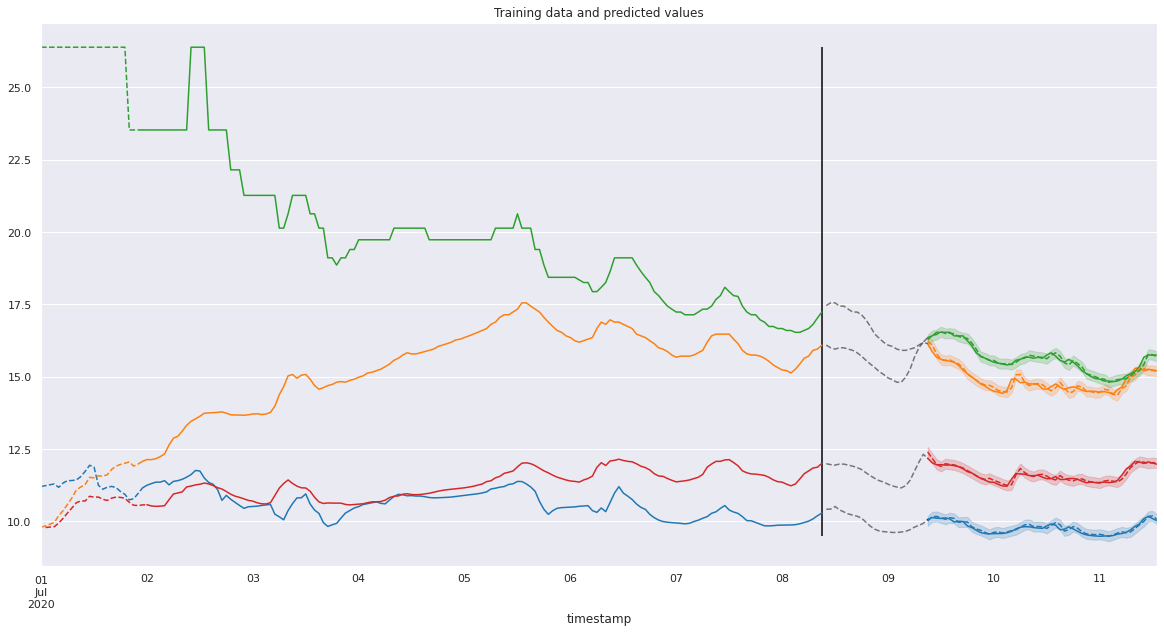

In [173]:
min_val, max_val = df_combined['t0'].min(), df_combined['t0'].max()
ax = df_prediction[['t0']].unstack(level=0).plot(figsize=(20, 10))
colors = [line.get_color() for line in ax.get_lines()]
df_prediction[['t0_pred']].unstack(level=0).plot(ax=ax, color=colors, linestyle='--')
# ax = df_prediction.unstack(level=0).plot(figsize=(20, 5))
df_train_shifted[['t0']].unstack(level=0).plot(ax=ax, color=colors)
ax.vlines(time_split, ymin=min_val, ymax=max_val)

for i, sensor_id in enumerate(df_prediction.index.get_level_values(level=0).unique()):
  df_train.loc[sensor_id].iloc[:T].plot(ax=ax, color=colors[i], linestyle='--')
  df_test.loc[sensor_id].iloc[:T].plot(ax=ax, color='black', alpha=0.5, linestyle='--')

  # Plot confidence interval
  x = df_prediction.loc[sensor_id].index
  lower = df_prediction.loc[sensor_id, 'lower'].values
  upper = df_prediction.loc[sensor_id, 'upper'].values
  # ax.fill_between(x, lower, upper, color='b', alpha=0.2)
  ax.fill_between(x, lower, upper, color=colors[i], alpha=0.2)
ax.get_legend().remove()
_ = ax.set_title('Training data and predicted values')

# Save model to Cloud Storage

In [184]:
from datetime import datetime
import tempfile

from google.cloud import storage
import joblib

# Define filename
now = datetime.utcnow()
filename = now.strftime('%Y-%m-%d-%H-%M-%S.joblib')

# Instantiates storage client
storage_client = storage.Client()

# Get bucket
# bucket_name = 'beresourceful-sund-sensor-dev-models'
bucket_name = 'beresourceful-sund-sensor-prod-models'
bucket = storage_client.bucket(bucket_name)
blob_path = 'sensor-linear-regression-models/{}'.format(filename)

with tempfile.NamedTemporaryFile() as f:
  joblib.dump(reg, f.name)
  f.seek(0)

  # Upload file
  blob = bucket.blob(blob_path)
  blob.upload_from_filename(f.name)

  print("Model save and uploaded to {}.".format(blob_path))

Model save and uploaded to sensor-linear-regression-models/2020-07-11-15-40-08.joblib.


# Test load from storage

In [187]:
# Instantiates storage client
storage_client = storage.Client()

# Get bucket
# bucket_name = 'beresourceful-sund-sensor-dev-models'
bucket_name = 'beresourceful-sund-sensor-prod-models'
bucket = storage_client.bucket(bucket_name)
blob_path = 'sensor-linear-regression-models/2020-07-11-15-40-08.joblib'

blob = bucket.blob(blob_path)

with tempfile.NamedTemporaryFile() as f:
  blob.download_to_filename(f.name)
  reg_loaded = joblib.load(f.name)

print('Loaded model from {}'.format(blob_path))
reg_loaded

Loaded model from sensor-linear-regression-models/2020-07-11-15-40-08.joblib


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)